In [179]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import json
import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy
import emoji

from wordcloud import WordCloud

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import des modules contenant les fonctions utilitaires
import src.data_helpers as dth

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\romai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\romai\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [164]:
# Réglage des graphiques
plt.style.use('seaborn-whitegrid')

plt.rc('font', size=12)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

dims_fig = (25,20)

In [2]:
bad_reviews = pd.read_csv('bad_reviews.csv', sep=',')

In [8]:
dth.displayDataShape('Le fichier bad_reviews contient', bad_reviews)

Le fichier bad_reviews contient : 630871 lignes et 4 colonnes



In [223]:
bad_reviews.head()

,business_id,categories,stars,text
0,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,Horrible 3rd world service. After I picked out...
1,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,"Looks like a nice place from the outside, but ..."
2,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,bun is sucked here and the waitress was really...
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,TERRIBLE TERRIBLE service. I have never felt s...
4,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,Not sure what happen. I have order a taro cake...


In [224]:
test_reviews = bad_reviews[0:100]
test_reviews

,business_id,categories,stars,text
0,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,Horrible 3rd world service. After I picked out...
1,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,"Looks like a nice place from the outside, but ..."
2,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,bun is sucked here and the waitress was really...
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,TERRIBLE TERRIBLE service. I have never felt s...
4,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.0,Not sure what happen. I have order a taro cake...
...,...,...,...,...
95,9OG5YkX1g2GReZM0AskizA,"Restaurants, Italian",1.0,We typically go to Macaroni Grill to celebrat...
96,9OG5YkX1g2GReZM0AskizA,"Restaurants, Italian",1.0,"If there was an option for no stars, this rest..."
97,9OG5YkX1g2GReZM0AskizA,"Restaurants, Italian",1.0,"I used to eat here weekly, but have been consi..."
98,9OG5YkX1g2GReZM0AskizA,"Restaurants, Italian",1.0,"I'm very sad to give a poor review, as Macaron..."


In [53]:
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+')

def tokenize_text(text):
    return tokenizer.tokenize(emoji.demojize(text, delimiters=("", "")).lower())

In [69]:
def freq_stats_corpora():
    corpora = dict()

    # Création d'un corpus de tokens
    for row in range(test_reviews.shape[0]):
        corpora[row] = tokenize_text(test_reviews['text'][row])

    stats, freq = dict(), dict()

    for k in corpora:
        freq[k] = nltk.FreqDist(corpora[k])
        stats[k] = {'total': len(corpora[k])} 
        
    return (freq, stats, corpora)

# Récupération des comptages
freq, stats, corpora = freq_stats_corpora()

In [124]:
freq_totale = nltk.Counter()
for k in corpora:
    freq_totale += freq[k]

In [218]:
most_frequent = tuple(zip(*freq_totale.most_common(20)))[0]

In [127]:
sw = set()
sw.update(most_frequent)
sw.update(tuple(stopwords.words('english')))

In [134]:
def freq_stats_corpora_sw():
    corpora = dict()

    # Création d'un corpus de tokens
    for row in range(test_reviews.shape[0]):
        tokens = tokenize_text(test_reviews['text'][row])
        corpora[row] = [w for w in tokens if w not in sw]

    stats, freq = dict(), dict()

    for k in corpora:
        freq[k] = nltk.FreqDist(corpora[k])
        stats[k] = {'total': len(corpora[k])} 
        
    return (freq, stats, corpora)

# Récupération des comptages
freq2, stats2, corpora2 = freq_stats_corpora_sw()

In [153]:

lemmatizer = WordNetLemmatizer()

def freq_stats_corpora_sw_lem():
    corpora = dict()

    # Création d'un corpus de tokens
    for row in range(test_reviews.shape[0]):
        tokens = tokenize_text(test_reviews['text'][row])
        corpora[row] = [lemmatizer.lemmatize(w) for w in tokens if w not in sw]

    stats, freq = dict(), dict()

    for k in corpora:
        freq[k] = nltk.FreqDist(corpora[k])
        stats[k] = {'total': len(corpora[k])} 
        
    return (freq, stats, corpora)

# Récupération des comptages
freq3, stats3, corpora3 = freq_stats_corpora_sw_lem()

In [170]:
extract = " ".join([text for text in bad_reviews['text'].sample(10000,random_state=42)])

In [229]:
clean_extract = " ".join([w for w in extract.lower().split(" ") if w not in sw])

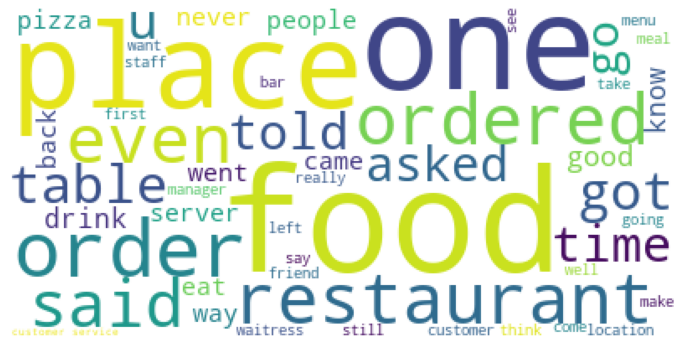

In [230]:
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(clean_extract)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [220]:
def tokenize(text):
    tokens = tokenize_text(text)
    return [lemmatizer.lemmatize(w) for w in tokens if w not in sw and len(w) > 3]
    

In [225]:
cv = CountVectorizer(tokenizer=tokenize, stop_words=sw)
data_cv = cv.fit_transform(test_reviews['text'])
data_cv_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_cv_dtm.index = test_reviews.index
data_cv_dtm

,aaron,able,absolutely,absorbed,access,accessible,accommodation,accordingly,acknowledge,acknowledged,...,write,wrong,yeah,year,yelp,yesterday,young,yuck,zero,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,1,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


In [226]:
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=sw)
data_tfidf = tfidf.fit_transform(test_reviews['text'])
data_tfidf_dtm = pd.DataFrame(data_tfidf.toarray(), columns=tfidf.get_feature_names_out())
data_tfidf_dtm.index = test_reviews.index
data_tfidf_dtm

,aaron,able,absolutely,absorbed,access,accessible,accommodation,accordingly,acknowledge,acknowledged,...,write,wrong,yeah,year,yelp,yesterday,young,yuck,zero,zucchini
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.230762,0.0,0.000000,0.0,0.0,0.0,0.176519,0.000000,0.000000
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.128935,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.090347,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.056155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.043960,0.0,0.0,0.0,0.000000,0.000000,0.122392
96,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.143374,0.0,0.0,0.0,0.000000,0.085741,0.000000
97,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.191429,0.0,0.0,0.0,0.000000,0.000000,0.000000
98,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.172337,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [265]:
from gensim import matutils,models
import gensim.corpora as corpora
import scipy.sparse

In [235]:
tdm = data_cv_dtm.transpose()
tdm.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
aaron,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
absolutely,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
absorbed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
access,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [272]:
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [273]:
id2word = dict((k, v) for k, v in corpora3.items())
id2word

{0: ['horrible',
  'rd',
  'world',
  'service',
  'picked',
  'pastry',
  'asked',
  'box',
  'woman',
  'behind',
  'counter',
  'scolded',
  'ask',
  'advance',
  'proceeded',
  'take',
  'pastry',
  'little',
  'bag',
  'put',
  'box',
  'asked',
  'necessary',
  'response',
  'get',
  'bag',
  'box',
  'nearly',
  'fainted',
  'guess',
  'going',
  'use',
  'bag',
  'unfathomable',
  'grown',
  'as',
  'adult',
  'spending',
  'hard',
  'earned'],
 1: ['look',
  'like',
  'nice',
  'place',
  'outside',
  'bubble',
  'tea',
  'really',
  'sucked',
  'going',
  'blend',
  'ice',
  'least',
  'smooth',
  'gritty',
  'rocky',
  'also',
  'something',
  'wrong',
  'green',
  'tea',
  'bubble',
  'tea',
  'look',
  'white',
  'green',
  'bubble',
  'wrong',
  'texture',
  'yuck',
  'also',
  'ordered',
  'egg',
  'tart',
  'good',
  'based',
  'experience',
  'though',
  'desire',
  'coming',
  'back'],
 2: ['bun',
  'sucked',
  'waitress',
  'really',
  'mean',
  'cheap',
  'never',
 

In [274]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

IndexError: index 18 is out of bounds for axis 1 with size 10